## Problem definition
Show the accuracy of the Monaghan-Gingold laplacian operator
by computing the laplacian of the following function,

$$
    f(x, y) = \sin(2 \pi (x+y)),
$$

on a periodic domain with the points/particles placed on both
a uniform grid and a perturbed grid. For the perturbation case
the particles are randomly moved from their original position
on a uniform grid by at most $k\Delta x$, $k$ being a constant
which we set as $0.01$. The exact solution of the laplacian
is given by,

$$
    \frac{\partial^2 f}{\partial x^2}(x, y) + 
    \frac{\partial^2 f}{\partial y^2}(x, y) = 
    -8\pi^2\sin(2 \pi (x+y)).
$$

A smoothing length factor, $h/\Delta x = 1.2$, is used in this
simulation. The value of the Monaghan-Gingold viscous operator
at a particle $i$ is given by,

$$
    <\nabla \cdot \nabla f(x_i, y_i)>_{\text{SPH Approx}} =
    \sum_j \frac{4 m_j}{\rho_i + \rho_j}
    (f(x_j, y_j) - f(x_i, y_i) 
    \frac{\nabla W(\mathbf{x}_{ij}, h_{ij})
    \cdot \mathbf{x}_{ij}}{|\mathbf{x}_{ij}| + \epsilon}
$$

where the vector $\mathbf{x}_{ij} = [x_i - x_j, y_i, y_j]^T$ is the difference between the position of the particles $i$ and $j$,
$ W(\mathbf{x}_{ij}, h_{ij})$ is the kernel function, $m_j$ is the masss of the particle, $rho_i$ is the density of the particle. The summation is done over all the neighboring particles of particle $i$.

In [1]:
# Numpy and matplotlib imports to define functions
# and make high quality plots.
import numpy as np
from numpy import cos, sin, pi
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import rc, patches, colors

# PySPH is the SPH framework on top which we 
# implemented Adaptive SPH
from pysph.base.kernels import QuinticSpline
from pysph.base.nnps import DomainManager
from pysph.base.utils import get_particle_array 
from pysph.sph.equation import Equation, Group
from pysph.tools.sph_evaluator import SPHEvaluator

In [2]:
%matplotlib inline

# Configuration to generate quality plots
rc('legend', fontsize='medium')
rc('axes', grid=True, linewidth=1.5, titlesize='medium')
rc('axes.grid', which='both', axis='both')
rc('grid', linewidth=0.5, linestyle='--')
rc('xtick', direction='in', top=True)
rc('ytick', direction='in', right=True)
rc('lines', linewidth=2.0)

In [3]:
# Size of the square domain; 
sizex = 1
sizey = 1

In [4]:
# Standard summation density equation. First, the `initialize` method
# is run over all the particles. Then, the `loop` method is run over
# all the neighboring particles of all the particles in the domain.

class SummationDensity(Equation):
    def initialize(self, d_idx, d_rho):
        d_rho[d_idx] = 0.0

    def loop(self, d_idx, s_idx, d_rho, s_m, WIJ):
        d_rho[d_idx] += s_m[s_idx]*WIJ


class LaplacianOperator(Equation):
    def __init__(self, dest, sources, nu):
        self.nu = nu
        super().__init__(dest, sources)

    def initialize(self, d_idx, d_d2f_dx2):
        d_d2f_dx2[d_idx] = 0.0

    def loop(self, d_idx, s_idx, d_rho, s_rho, s_m, d_d2f_dx2,
             R2IJ, EPS, DWIJ, d_f, s_f, XIJ):
        dw_dot_xij = DWIJ[0]*XIJ[0] + DWIJ[1]*XIJ[1] + DWIJ[2]*XIJ[2]

        Vj = s_m[s_idx] / (d_rho[d_idx] + s_rho[s_idx])

        tmp = Vj * 4 * self.nu * dw_dot_xij/(R2IJ + EPS)

        d_d2f_dx2[d_idx] += tmp * (d_f[d_idx] - s_f[s_idx])

In [5]:
def create_domain(lx, ly):
    return DomainManager(xmin=-lx, xmax=lx, ymin=-ly, ymax=ly,
                         periodic_in_x=True, periodic_in_y=True)


def create_particles(dx, perturb, hdx):
    dim = 2
    _x = np.arange(-sizex+dx/2, sizex, dx)
    _y = np.arange(-sizey+dx/2, sizey, dx)
    x, y = np.meshgrid(_x, _y)

    m = dx**dim
    h = hdx * dx

    if perturb > 0.0:
        np.random.seed(1234)
        
        # Randomly displace the particles by atmost perturb \times dx.
        x += np.random.random(x.shape) * perturb * dx
        y += np.random.random(y.shape) * perturb * dx

    fluid = get_particle_array(name='fluid', x=x, y=y, h=h, m=m, rho=1.0)

    props = ['f', 'f_approx', 'd2f_dx2', 'laplace_exact', 'f_exact']
    for prop in props:
        fluid.add_property(prop)
    fluid.add_property('m_mat', stride=9)
    fluid.add_property('gradf', stride=3)
    return fluid


def create_equations(fluid, kernel):
    eqns = []
    eqns.append(Group(
        equations=[SummationDensity(fluid.name, [fluid.name])],
        update_nnps=True
    ))
    eqns.append(Group(
        equations=[LaplacianOperator(fluid.name, [fluid.name], nu=1.0)]
    ))
    
    domain_manager = create_domain(lx=sizex, ly=sizey)
    sph_eval = SPHEvaluator(
        arrays=[fluid], equations=eqns, dim=2,
        kernel=kernel, domain_manager=domain_manager
    )
    return sph_eval

In [6]:
def compute_approximation(dx=0.05, perturb=0.0, hdx=1.2):
    kernel = QuinticSpline(dim=2)
    fluid = create_particles(dx, perturb, hdx)

    x, y = fluid.x, fluid.y
    f_exact = sin(2*pi*(x+y))

    d2fdx2_exact = -(2*pi)**2 * sin(2*pi * (x+y))
    d2fdy2_exact = -(2*pi)**2 * sin(2*pi * (x+y))
    laplace_exact = d2fdx2_exact + d2fdy2_exact

    fluid.f[:] = f_exact
    fluid.f_exact[:] = f_exact
    fluid.laplace_exact = laplace_exact

    sph_eval = create_equations(fluid, kernel)
    sph_eval.update()
    sph_eval.evaluate()
    lap_err = np.sum(np.abs(fluid.d2f_dx2 - laplace_exact)) / len(fluid.x)
    return fluid, lap_err
    

def plot(fluid):
    plt.scatter(fluid.x, fluid.y, c=fluid.d2f_dx2, s=2, cmap='jet')
    plt.title("SPH laplacian approximation")
    plt.colorbar()
    plt.show()
    
    plt.scatter(fluid.x, fluid.y, c=fluid.laplace_exact, s=2, cmap='jet')
    plt.title("Exact laplacian")
    plt.colorbar()
    plt.show()
    
    plt.scatter(fluid.x, fluid.y, c=np.abs(fluid.laplace_exact-fluid.d2f_dx2), s=2, cmap='jet')
    plt.title("Error in SPH approximation")
    plt.colorbar()
    plt.show()

In [7]:
fluid, lap_err = compute_approximation(dx=0.02, perturb=0.01, hdx=1.2)

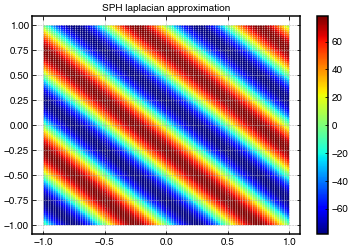

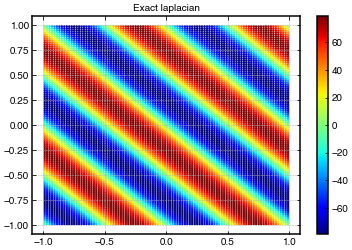

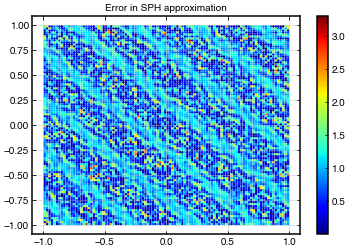

In [8]:
plot(fluid)

In [9]:
dxs = np.array([0.02, 0.01, 0.005, 0.0025, 0.00125])
hdx = 1.2
laplace_error = []
for dx in dxs:
    fluid, lap_err = compute_approximation(dx=dx, perturb=0.0, hdx=hdx)
    laplace_error.append(lap_err)
print(laplace_error)

[0.6855981975861759, 0.48146715102201926, 0.4302066275745704, 0.41737722499457575, 0.4141689817940048]


In [10]:
laplace_error_pert = []
for dx in dxs:
    perturb = 0.01
    fluid, lap_err = compute_approximation(dx=dx, perturb=perturb, hdx=hdx)
    laplace_error_pert.append(lap_err)
print(laplace_error_pert)

[0.8904724982563561, 1.1358905381177804, 2.0332255791350593, 3.9188493211488944, 7.768168786946836]


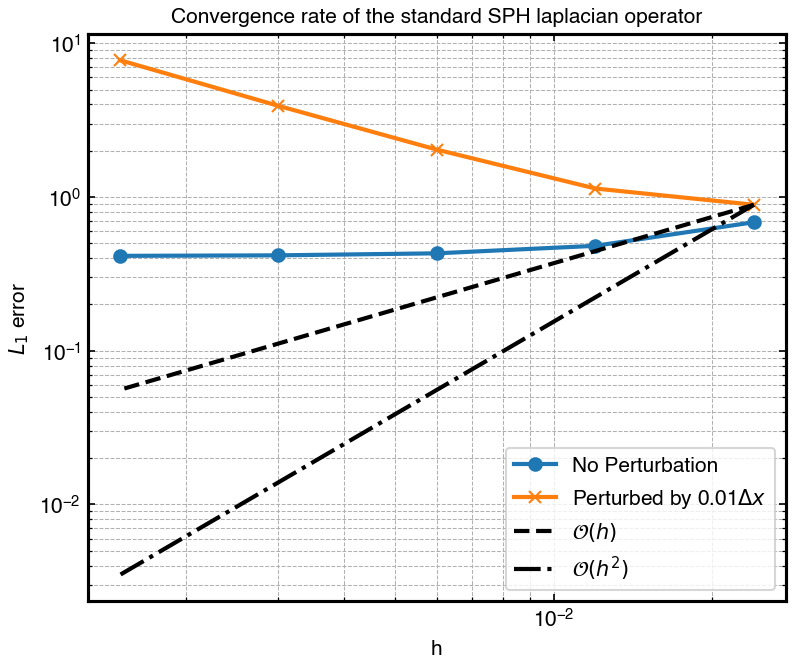

In [18]:
h = 1.2 * dxs
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
ax.loglog(h, laplace_error, '-o', label='No Perturbation')
ax.loglog(h, laplace_error_pert, '-x', label=fr'Perturbed by {perturb}$\Delta x$')
ax.loglog(h,  laplace_error_pert[0] * (h/h[0])**1, '--k', label=r'$\mathcal{O}(h)$')
ax.loglog(h,  laplace_error_pert[0] * (h/h[0])**2, '-.k', label=r'$\mathcal{O}(h^2)$')
ax.set_title("Convergence rate of the standard SPH laplacian operator")
ax.set_xlabel('h')
ax.set_ylabel(r'$L_1$ error')
ax.legend()